#CLASSIFICATION OF HISTOPATHOLOGICAL SLIDE WITH TRANSFER LEARNING

This notebook contains the code to load, preprocess data and build a model to classify the histopoathological slide.

Cristian Drudi MSc, Politecnico di Milano, 2023.

If you use any of this code, please reference appropriately.

This code is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY, without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

In [ ]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Preprocessing

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import EfficientNetB7
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from tensorflow import keras
import seaborn as sns


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):# ,augment):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpeg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))

#            if augment == 1:
#              img_1 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#              img_2 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#              IMG.append(np.array(img_1))
#              IMG.append(np.array(img_2))

    return IMG

DOWNSAMPLED_SIZE=224
colon_n_train = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TrainingSet/colon_n',DOWNSAMPLED_SIZE))
colon_aca_train = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TrainingSet/colon_aca',DOWNSAMPLED_SIZE))
lung_n_train = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TrainingSet/lung_n',DOWNSAMPLED_SIZE))
lung_aca_train = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TrainingSet/lung_aca',DOWNSAMPLED_SIZE))
lung_scc_train = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TrainingSet/lung_scc',DOWNSAMPLED_SIZE))

colon_n_test = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TestSet/colon_n',DOWNSAMPLED_SIZE))
colon_aca_test = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TestSet/colon_aca',DOWNSAMPLED_SIZE))
lung_n_test = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TestSet/lung_n',DOWNSAMPLED_SIZE))
lung_aca_test = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TestSet/lung_aca',DOWNSAMPLED_SIZE))
lung_scc_test = np.array(Dataset_loader('/content/drive/MyDrive/AI_Images/Data/TestSet/lung_scc',DOWNSAMPLED_SIZE))

100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


# Create Label

In [ ]:
# Multiclass cancer classification
# Create labels
colon_n_train_label = np.zeros(len(colon_n_train))
colon_aca_train_label = np.ones(len(colon_aca_train))
lung_n_train_label = np.ones(len(lung_n_train))*2
lung_aca_train_label = np.ones(len(lung_aca_train))*3
lung_scc_train_label = np.ones(len(lung_scc_train))*4

colon_n_test_label = np.zeros(len(colon_n_test))
colon_aca_test_label = np.ones(len(colon_aca_test))
lung_n_test_label = np.ones(len(lung_n_test))*2
lung_aca_test_label = np.ones(len(lung_aca_test))*3
lung_scc_test_label = np.ones(len(lung_scc_test))*4

# Merge data
X_train = np.concatenate((colon_n_train, colon_aca_train, lung_n_train, lung_aca_train, lung_scc_train), axis = 0)
Y_train = np.concatenate((colon_n_train_label, colon_aca_train_label, lung_n_train_label, lung_aca_train_label, lung_scc_train_label), axis = 0)

X_test = np.concatenate((colon_n_test, colon_aca_test, lung_n_test, lung_aca_test, lung_scc_test), axis = 0)
Y_test = np.concatenate((colon_n_test_label, colon_aca_test_label, lung_n_test_label, lung_aca_test_label, lung_scc_test_label), axis = 0)

In [ ]:
# Multiclass cancer classification
# Create labels
colon_n_train_label = np.zeros(len(colon_n_train))
colon_aca_train_label = np.ones(len(colon_aca_train))
lung_n_train_label = np.ones(len(lung_n_train))*2
lung_aca_train_label = np.ones(len(lung_aca_train))*3
lung_scc_train_label = np.ones(len(lung_scc_train))*4

colon_n_test_label = np.zeros(len(colon_n_test))
colon_aca_test_label = np.ones(len(colon_aca_test))
lung_n_test_label = np.ones(len(lung_n_test))*2
lung_aca_test_label = np.ones(len(lung_aca_test))*3
lung_scc_test_label = np.ones(len(lung_scc_test))*4

# Merge data
X_train = np.concatenate((colon_n_train, colon_aca_train, lung_n_train, lung_aca_train, lung_scc_train), axis = 0)
Y_train = np.concatenate((colon_n_train_label, colon_aca_train_label, lung_n_train_label, lung_aca_train_label, lung_scc_train_label), axis = 0)

X_test = np.concatenate((colon_n_test, colon_aca_test, lung_n_test, lung_aca_test, lung_scc_test), axis = 0)
Y_test = np.concatenate((colon_n_test_label, colon_aca_test_label, lung_n_test_label, lung_aca_test_label, lung_scc_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 5)
Y_test = to_categorical(Y_test, num_classes= 5)

# Train and Evalutation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=42
)

# Data Generator

In [ ]:
BATCH_SIZE = 8

# Using original generator
train_generator = ImageDataGenerator(
        #preprocessing_function=keras.applications.mobilenet_v2.preprocess_input,
        #zoom_range=2,  # set range for random zoom
        rotation_range = 45,
        #horizontal_flip=True,  # randomly flip images
        #vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [ ]:
K.clear_session()
gc.collect()

base_model = EfficientNetB7(
    weights='imagenet',
    input_shape=(DOWNSAMPLED_SIZE, DOWNSAMPLED_SIZE, 3),
    include_top=False)
#base_model.trainable = False

inputs = keras.Input(shape=(DOWNSAMPLED_SIZE, DOWNSAMPLED_SIZE, 3))
#x = data_augmentation(inputs) 
#x = tf.keras.applications.xception.preprocess_input(inputs) #already included in efficientnet pipeline
x = base_model(inputs)#, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
model.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                            

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.1, min_lr=1e-10)
#Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

# Checkpoint
filepath="/content/drive/MyDrive/AI_Images/Model/EfficientNetB7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=500,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, early_stopping, checkpoint]
)

Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8625
Epoch 1: val_accuracy improved from -inf to 0.97400, saving model to /content/drive/MyDrive/AI_Images/Model/EfficientNetB7.hdf5
500/500 [==============================] - 326s 561ms/step - loss: 0.3977 - accuracy: 0.8625 - val_loss: 0.0861 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 2/500
500/500 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9442
Epoch 2: val_accuracy improved from 0.97400 to 0.97600, saving model to /content/drive/MyDrive/AI_Images/Model/EfficientNetB7.hdf5
500/500 [==============================] - 293s 586ms/step - loss: 0.1583 - accuracy: 0.9442 - val_loss: 0.0647 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 3/500
500/500 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9600
Epoch 3: val_accuracy improved from 0.97600 to 0.98000, saving model to /content/drive/MyDrive/AI_Images/Model/EfficientNetB7.hdf5
500/500 [======

In [ ]:
# convert the history.history dict to a pandas DataFrame: 
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/drive/MyDrive/AI_Images/Model/history/history_EfficientNetB7.json' 
with open(hist_json_file, mode='wb') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/AI_Images/Model/history/history_EfficientNetB7.csv'
with open(hist_csv_file, mode='wb') as f:
    hist_df.to_csv(f)

Text(0.5, 0, 'Epochs')

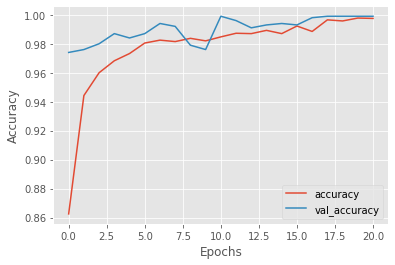

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

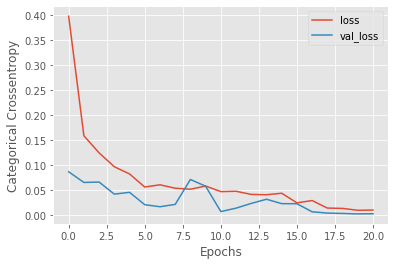

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.ylabel('Categorical Crossentropy')
plt.xlabel('Epochs')

# Prediction

In [ ]:
model.load_weights(filepath)

In [ ]:
Y_val_pred = model.predict(x_val)

32/32 [==============================] - 729s 22s/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.999

In [ ]:
Y_pred = model.predict(X_test)

4/4 [==============================] - 70s 16s/step


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
    plt.figure(figsize=(40, 20))

Confusion matrix, without normalization
[[199   0   0   0   0]
 [  0 189   0   0   0]
 [  0   0 214   0   0]
 [  0   0   0 208   0]
 [  0   0   0   1 189]]


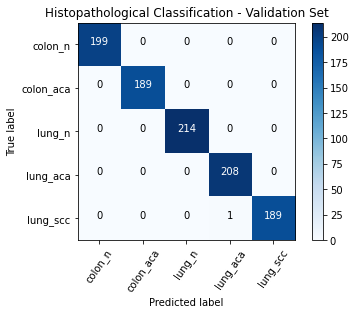

<Figure size 2880x1440 with 0 Axes>

In [ ]:
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
cm_plot_label =['colon_n', 'colon_aca','lung_n','lung_aca','lung_scc']
plot_confusion_matrix(cm, cm_plot_label, title ='Histopathological Classification - Validation Set')

Confusion matrix, without normalization
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


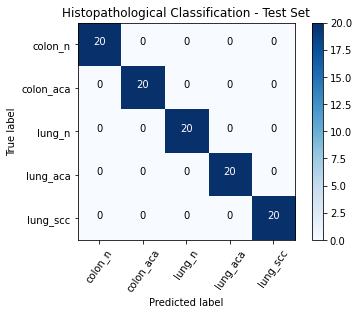

<Figure size 2880x1440 with 0 Axes>

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
cm_plot_label =['colon_n', 'colon_aca','lung_n','lung_aca','lung_scc']
plot_confusion_matrix(cm, cm_plot_label, title ='Histopathological Classification - Test Set')

### Classification Report

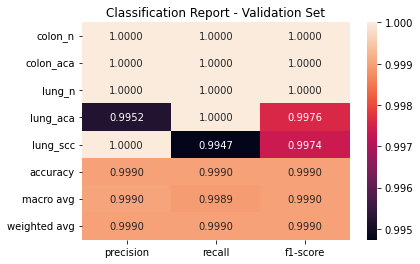

<Figure size 2880x1440 with 0 Axes>

In [ ]:
clf_report = classification_report(np.argmax(y_val, axis=1),
                                   np.argmax(Y_val_pred, axis=1),
                                   labels=np.arange(5),
                                   target_names=['colon_n', 'colon_aca','lung_n','lung_aca','lung_scc'],
                                   output_dict=True)
# .iloc[:-1, :] to exclude support
ax = plt.axes()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, ax=ax, annot=True, fmt=".4f")
ax.set_title('Classification Report - Validation Set')
plt.figure(figsize=(40, 20))
plt.show()

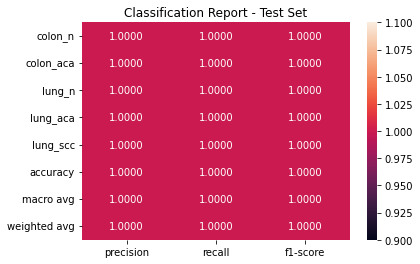

<Figure size 2880x1440 with 0 Axes>

In [ ]:
clf_report = classification_report(np.argmax(Y_test, axis=1),
                                   np.argmax(Y_pred, axis=1),
                                   labels=np.arange(5),
                                   target_names=['colon_n', 'colon_aca','lung_n','lung_aca','lung_scc'],
                                   output_dict=True)
# .iloc[:-1, :] to exclude support
ax = plt.axes()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, ax=ax, annot=True, fmt=".4f")
ax.set_title('Classification Report - Test Set')
plt.figure(figsize=(40, 20))
plt.show()

#ROC

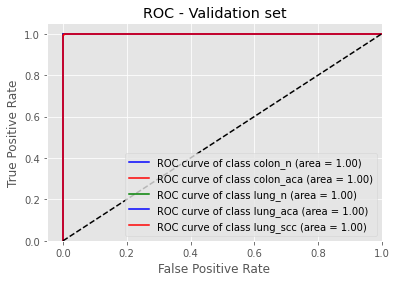

<Figure size 2880x1440 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
plt.style.use('ggplot')
n_classes=5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cm_plot_label[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Validation set')
plt.legend(loc="lower right")
plt.figure(figsize=(40, 20))
plt.show()

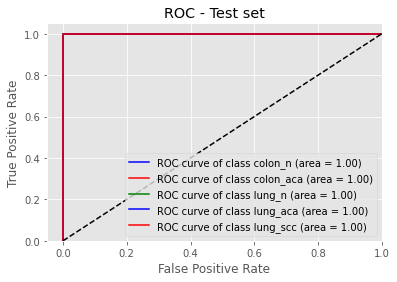

<Figure size 2880x1440 with 0 Axes>

In [ ]:
plt.style.use('ggplot')
n_classes=5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cm_plot_label[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test set')
plt.legend(loc="lower right")
plt.figure(figsize=(40, 20))
plt.show()

In [ ]:
Y_pred

array([[9.99999940e-01, 2.14148397e-08, 1.73579012e-10, 1.34285351e-13,
        1.80699100e-08],
       [2.98685450e-07, 3.02088125e-07, 1.26375118e-04, 9.18036222e-01,
        8.18367451e-02],
       [9.99997795e-01, 2.18700757e-06, 9.75394587e-18, 3.29570864e-22,
        1.58122349e-10],
       [1.82233695e-09, 7.60758212e-09, 8.33607683e-10, 9.99999940e-01,
        4.68314232e-09],
       [7.23892226e-05, 1.02587521e-07, 7.84028146e-07, 9.98584628e-01,
        1.34207681e-03],
       [9.99996006e-01, 3.89457091e-06, 5.68484170e-13, 6.93901461e-16,
        2.28011410e-09],
       [3.81791665e-09, 9.99999225e-01, 2.44169152e-09, 6.56947805e-07,
        5.63821168e-09],
       [9.99999940e-01, 1.59972013e-09, 1.14585670e-18, 2.10963852e-16,
        5.76625503e-09],
       [2.81348729e-13, 1.13473952e-05, 3.14377674e-13, 9.99988496e-01,
        1.74458535e-07],
       [4.77070807e-06, 3.46773982e-06, 1.92864988e-07, 9.91914868e-01,
        8.07671342e-03],
       [2.72820811e-11, 9.9999

##JUNK

### ROC and AUC

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred,axis=1))#_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))#_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

ValueError: ignored

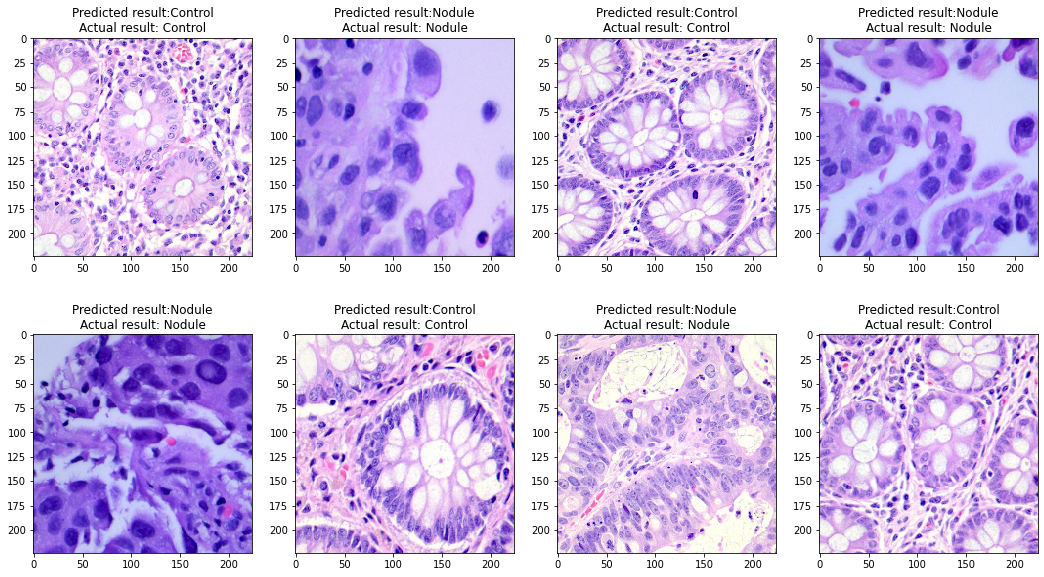

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Control"
    else:
        return "Nodule"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

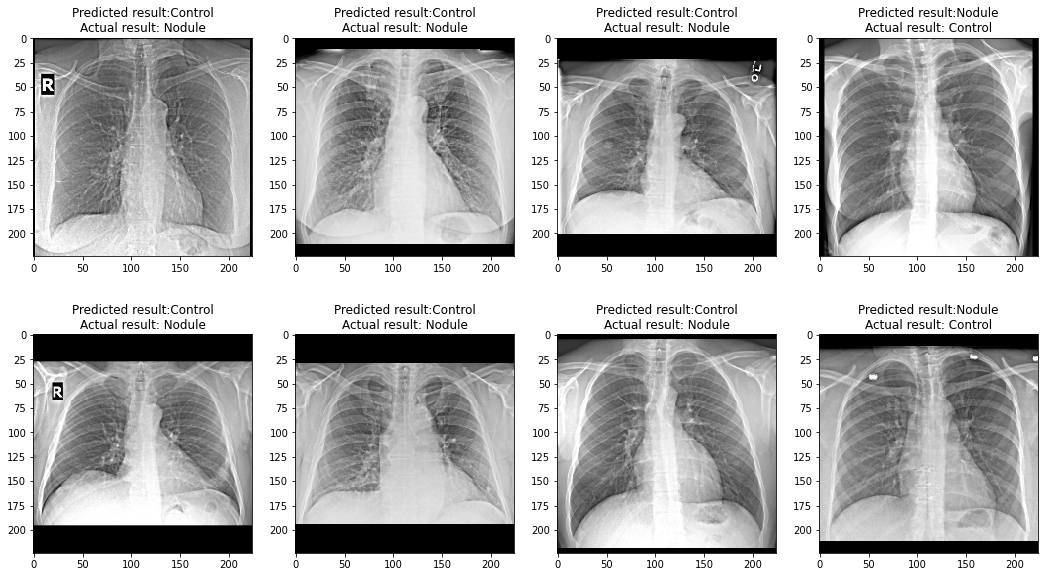

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Control"
    else:
        return "Nodule"
    
for i in range(len(mis_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[mis_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[mis_class[i]])))
    plt.imshow(X_test[mis_class[i]], interpolation='nearest')
plt.show()

In [ ]:
import os, shutil
#os.chdir("/content/drive/MyDrive/AI_Images/Data")
from os import path
with open('/content/drive/MyDrive/AI_Images/test_lung_scc.txt','r') as f:
    file_names = [l.strip() for l in f.readlines()]

for f in os.listdir("/content/drive/MyDrive/AI_Images/Data/TestSet"):
  for i in range(20):
    if f==file_names[i]:
      shutil.move("/content/drive/MyDrive/AI_Images/Data/TestSet/" + f, "/content/drive/MyDrive/AI_Images/Data/TestSet/lung_scc/")

In [ ]:
a=range(20)
a

range(0, 20)

In [ ]:
file_names

['Test_00106_ze.jpeg',
 'Test_00489_jf.jpeg',
 'Test_00920_iy.jpeg',
 'Test_00269_bt.jpeg',
 'Test_00942_ko.jpeg',
 'Test_00301_kz.jpeg',
 'Test_00539_sr.jpeg',
 'Test_00178_sr.jpeg',
 'Test_00171_dz.jpeg',
 'Test_00881_ao.jpeg',
 'Test_00368_re.jpeg',
 'Test_00156_lz.jpeg',
 'Test_00376_wq.jpeg',
 'Test_00482_el.jpeg',
 'Test_00226_dp.jpeg',
 'Test_00251_kp.jpeg',
 'Test_00265_hq.jpeg',
 'Test_00730_vz.jpeg',
 'Test_00107_ip.jpeg',
 'Test_00817_xw.jpeg']

In [ ]:
os.listdir("/content/drive/MyDrive/AI_Images/Data/TestSet")

In [ ]:
from os import path
with open('/content/drive/MyDrive/AI_Images/text_colon_n.txt','r') as f:
    file_names = [l.strip() for l in f.readlines()]
    exists = {fn: path.exists(fn) for fn in file_names}

In [ ]:
file_names

['Test_00106_ze.jpeg',
 'Test_00489_jf.jpeg',
 'Test_00920_iy.jpeg',
 'Test_00269_bt.jpeg',
 'Test_00942_ko.jpeg',
 'Test_00301_kz.jpeg',
 'Test_00539_sr.jpeg',
 'Test_00178_sr.jpeg',
 'Test_00171_dz.jpeg',
 'Test_00881_ao.jpeg',
 'Test_00368_re.jpeg',
 'Test_00156_lz.jpeg',
 'Test_00376_wq.jpeg',
 'Test_00482_el.jpeg',
 'Test_00226_dp.jpeg',
 'Test_00251_kp.jpeg',
 'Test_00265_hq.jpeg',
 'Test_00730_vz.jpeg',
 'Test_00107_ip.jpeg',
 'Test_00817_xw.jpeg']

In [ ]:
exists

{'Test_00106_ze.jpeg': False,
 'Test_00489_jf.jpeg': False,
 'Test_00920_iy.jpeg': False,
 'Test_00269_bt.jpeg': False,
 'Test_00942_ko.jpeg': False,
 'Test_00301_kz.jpeg': False,
 'Test_00539_sr.jpeg': False,
 'Test_00178_sr.jpeg': False,
 'Test_00171_dz.jpeg': False,
 'Test_00881_ao.jpeg': False,
 'Test_00368_re.jpeg': False,
 'Test_00156_lz.jpeg': False,
 'Test_00376_wq.jpeg': False,
 'Test_00482_el.jpeg': False,
 'Test_00226_dp.jpeg': False,
 'Test_00251_kp.jpeg': False,
 'Test_00265_hq.jpeg': False,
 'Test_00730_vz.jpeg': False,
 'Test_00107_ip.jpeg': False,
 'Test_00817_xw.jpeg': False}